# **Convex Optimization - Homework 3**

*Author : Paule Grangette*

In [1]:
# Libraries
import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

## **Question 1**

### Derive the dual problem of LASSO and format it as a general Quadratic Problem.

## **Question 2**

### Implement the barrier method to solve QP.

In [2]:
# Useful functions
def f_barr(Q, p, A, b, t, v):
  '''Computes the barrier function f_barr = t*f + $\phi$,
  where f(v) = v.T@Q@v+p.T@v and phi = - np.sum(np.log(b-A@v))'''
  if (b-A@v<=0).any() :
    raise ValueError("Inequality constraint is not satisfied. v is not feasible.")
  return t*(v.T@Q@v + p.T@v) - np.sum(np.log(b - A@v))

def grad_barr(Q, p, A, b, v, t):
  '''Computes the gradient of f_barr'''
  return t*((Q + Q.T) @ v +p) + np.sum((1/(b-A@v).T*A.T), axis=1).reshape(-1,1)

def hessian_barr(Q, p, A, b, t, v):
  '''Computes the hessian of f_barr'''
  r = lambda v: b-A @ v
  hess_phi = np.zeros((len(v), len(v)))
  for i in range(A.shape[0]):
    hess_phi += 1/(r(v)[i])**2 * A[i,:].reshape(-1,1)@A[i,:].reshape(1,-1)
  return 2*t*Q + hess_phi

def linesearch(Q, p, A, b, t, v, delta, lamb_sq, alpha, beta):
  '''Backtracking line search : the constant used is -lambda**2
  NB : alpha $\in$ (0, 1/2) and beta $\in$ (0,1)'''
  slope = 1
  while (b-A@(v+slope*delta)<=0).any() or (f_barr(Q,p,A,b,t,v+slope*delta) > f_barr(Q,p,A,b,t,v) - slope*alpha*lamb_sq):
    slope*=beta
  return slope


In [3]:
def centering_step(Q, p, A, b, t, v0, eps):

  alpha = 0.01
  beta = 0.5
  n_eps = 0
  v0_new = v0
  
  while True :
    v0 = v0_new
    #Compute the Newton step and decrement
    hess = hessian_barr(Q,p,A,b,t,v0)
    gradient = grad_barr(Q,p,A,b,v0,t)
    delta_v_nt = - LA.inv(hess) @ gradient
    lambda_square = float((-1)*gradient.T @ delta_v_nt)
    #Stopping criterion
    if lambda_square/2 <= eps :
      break
    #Line search
    slope = linesearch(Q, p, A, b, t, v0, delta_v_nt, lambda_square, alpha, beta)
    #Update
    n_eps += 1
    v0_new = v0 + slope*delta_v_nt
  
  return v0, n_eps

In [4]:
def barr_method(Q, p, A, b, v0, eps, mu):
  t = 1
  m = A.shape[0]
  precision_list = [m]
  n_list = [0]
  v_list = [v0]
  while True:
    #Centering step
    v0, n_eps = centering_step(Q,p,A,b,t,v0,eps)
    #Update the list
    v_list.append(v0)
    n_list.append(n_eps+n_list[-1])
    #Stopping criterion
    if m/t < eps :
      break
    #Increase t
    t = mu*t
    precision_list.append(t)
  return v_list, n_list, precision_list

## Question 3

In [6]:
#Let's generate X and y in the LASSO problem and define the model
lamb = 10
n_samples = 100
n_features = 400
std_noise = 1.4

X, y, w_min = make_regression(n_samples, n_features, coef=True, noise = std_noise, random_state=1)

Q = np.eye(n_samples)/2
p = (-y).reshape(-1,1)
A = np.vstack((X.T, -X.T))
b = lamb*np.ones((2*n_features, 1))
v0 = np.zeros((n_samples,1))
eps = 1e-05
mu = [2, 15, 50, 150, 750]

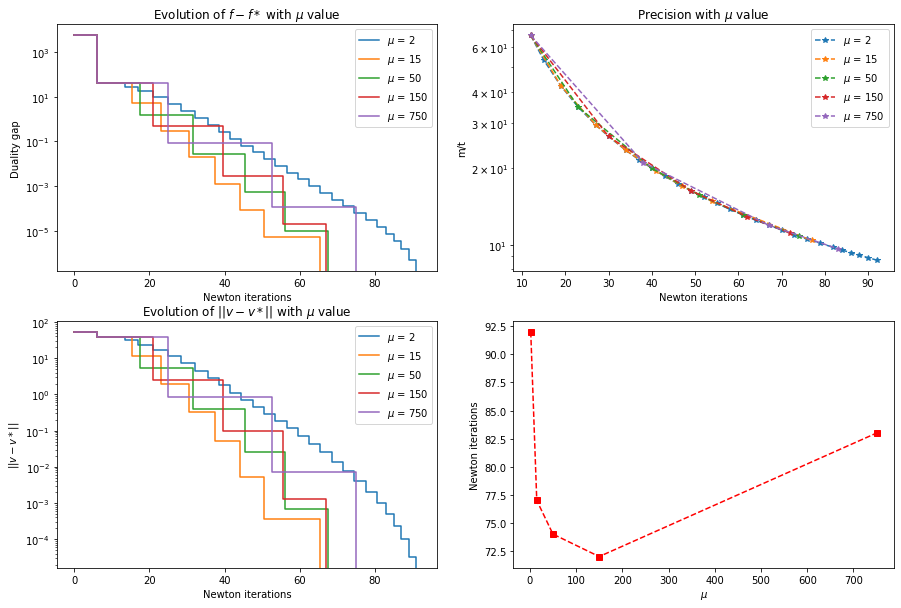

In [7]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
n_it_by_mu = []
n_sup_it_by_mu = []
for m in mu :
  v_seq, n_eps_seq, precision = barr_method(Q, p, A, b, v0, eps, m)
  v_best = v_seq[-1]
  v_diff = [np.sum(np.abs(v-v_best)) for v in v_seq]
  precision = [2*n_features/n for n in n_eps_seq[1:]]
  gap_traj = [float((v.T@Q@v + p.T@v) - (v_best.T@Q@v_best + p.T@v_best)) for v in v_seq]
  n_it_by_mu.append(n_eps_seq[-1])
  ax[0,0].step(n_eps_seq, gap_traj, where='mid', label = '$\mu$ = {}'.format(m))
  ax[1,0].step(n_eps_seq, v_diff, where='mid', label = '$\mu$ = {}'.format(m))
  ax[0,1].plot(n_eps_seq[1:], precision, '*--', label='$\mu$ = {}'.format(m))
ax[0,0].set_xlabel('Newton iterations')
ax[0,0].set_ylabel('Duality gap')
ax[0,0].set_title('Evolution of $f-f*$ with $\mu$ value')
ax[0,0].semilogy()
ax[0,0].legend()
ax[0,1].set_xlabel('Newton iterations')
ax[0,1].set_ylabel('m/t')
ax[0,1].set_title('Precision with $\mu$ value')
ax[0,1].semilogy()
ax[0,1].legend()
ax[1,0].set_xlabel('Newton iterations')
ax[1,0].set_ylabel('$||v-v*||$')
ax[1,0].set_title('Evolution of $||v-v*||$ with $\mu$ value')
ax[1,0].semilogy()
ax[1,0].legend()
ax[1,1].set_xlabel('$\mu$')
ax[1,1].set_ylabel('Newton iterations')
ax[1,1].plot(mu, n_it_by_mu,"rs--")
